한글 폰트 설치

In [1]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
!apt-get -qq -y install fonts-nanum > /dev/null

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [1]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설치

데이터 전처리

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#csv파일 경로 저장
file_path_1 = '/content/서울시 읍면동마스터 정보.csv'
file_path_2 = '/content/서울시 행정동별 지하철 총 승차 승객수 정보.csv' #일별 승객수 파악가능, 지하철역별 승객수가 아닌 행정동별 지하철 승객수
file_path_3 = '/content/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv' #지하철역별 승객수 파악가능, 일별이 아닌 월별 승객수

#csv파일 데이터 프레임으로 변환
town_info = pd.read_csv(file_path_1, encoding = 'cp949')
town_subway_info = pd.read_csv(file_path_2, encoding = 'cp949')
subway_info = pd.read_csv(file_path_3, encoding = 'cp949')

#subway_info의 승차 하차 값 합치기
subway_info.drop('작업일자', axis = 1, inplace = True)

for i in range(24):
  start_hour = str(i).zfill(2)
  end_hour = str(i + 1).zfill(2)

  p_in = f'{start_hour}시-{end_hour}시 승차인원'
  p_out = f'{start_hour}시-{end_hour}시 하차인원'

  end_hour = str((i + 1)%24).zfill(2)
  new_columns = f'{start_hour}시~{end_hour}시'

  subway_info[new_columns] = subway_info[p_in] + subway_info[p_out]
  subway_info.drop([p_in, p_out], axis = 1, inplace = True)

#컴럼명 변경
town_info_columns = ['행정동_ID', '행정동_명칭', '자치구_명칭', '시도_명칭']
town_subway_info_columns = ['기준_날짜', '행정동_ID', '승객수',
                     '00시~01시', '01시~02시', '02시~03시', '03시~04시', '04시~05시', '05시~06시', '06시~07시', '07시~08시', '08시~09시', '09시~10시', '10시~11시', '11시~12시',
                     '12시~13시','13시~14시', '14시~15시', '15시~16시', '16시~17시', '17시~18시', '18시~19시', '19시~20시', '20시~21시', '21시~22시', '22시~23시', '23시~00시']

town_info.columns = town_info_columns
town_subway_info.columns = town_subway_info_columns

#데이터 규합
info_integre = pd.merge(town_info, town_subway_info, on = '행정동_ID')

#결측값 제거
info_integre.dropna(subset = ['승객수'], inplace = True) #지하철 승객수가 0인 행정동 제거 정보

#print(town_info)
#print(town_subway_info)
#print(subway_info)
#print(info_integre)

데이터 시각화

In [41]:
#원하는 날짜와 원하는 자치구의 지하철 이용정보를 시각화
#원하는 날짜의 지하철 이용정보
day_label = [20250901] #원하는 날짜 배열
info_integre_custom = info_integre.loc[info_integre['기준_날짜'].isin(day_label)]

#원하는 자치구 지하철 이용정보
town_label = ['강남구', '송파구', '서초구'] #원하는 자치구 배열
info_integre_custom = info_integre_custom.loc[info_integre_custom['자치구_명칭'].isin(town_label)]

#데이터 melt
#시간대별로 행을 나눠 시각화 하기 유리하게 데이터 변환
id_cols = ['기준_날짜', '행정동_ID', '행정동_명칭', '자치구_명칭', '시도_명칭', '승객수']
hour_cols = ['00시~01시', '01시~02시', '02시~03시', '03시~04시', '04시~05시', '05시~06시', '06시~07시', '07시~08시', '08시~09시', '09시~10시', '10시~11시', '11시~12시',
             '12시~13시','13시~14시', '14시~15시', '15시~16시', '16시~17시', '17시~18시', '18시~19시', '19시~20시', '20시~21시', '21시~22시', '22시~23시', '23시~00시']

info_integre_melt = pd.melt(info_integre_custom, id_vars = id_cols, value_vars = hour_cols, var_name = '시간대', value_name = '시간대별_승객수')

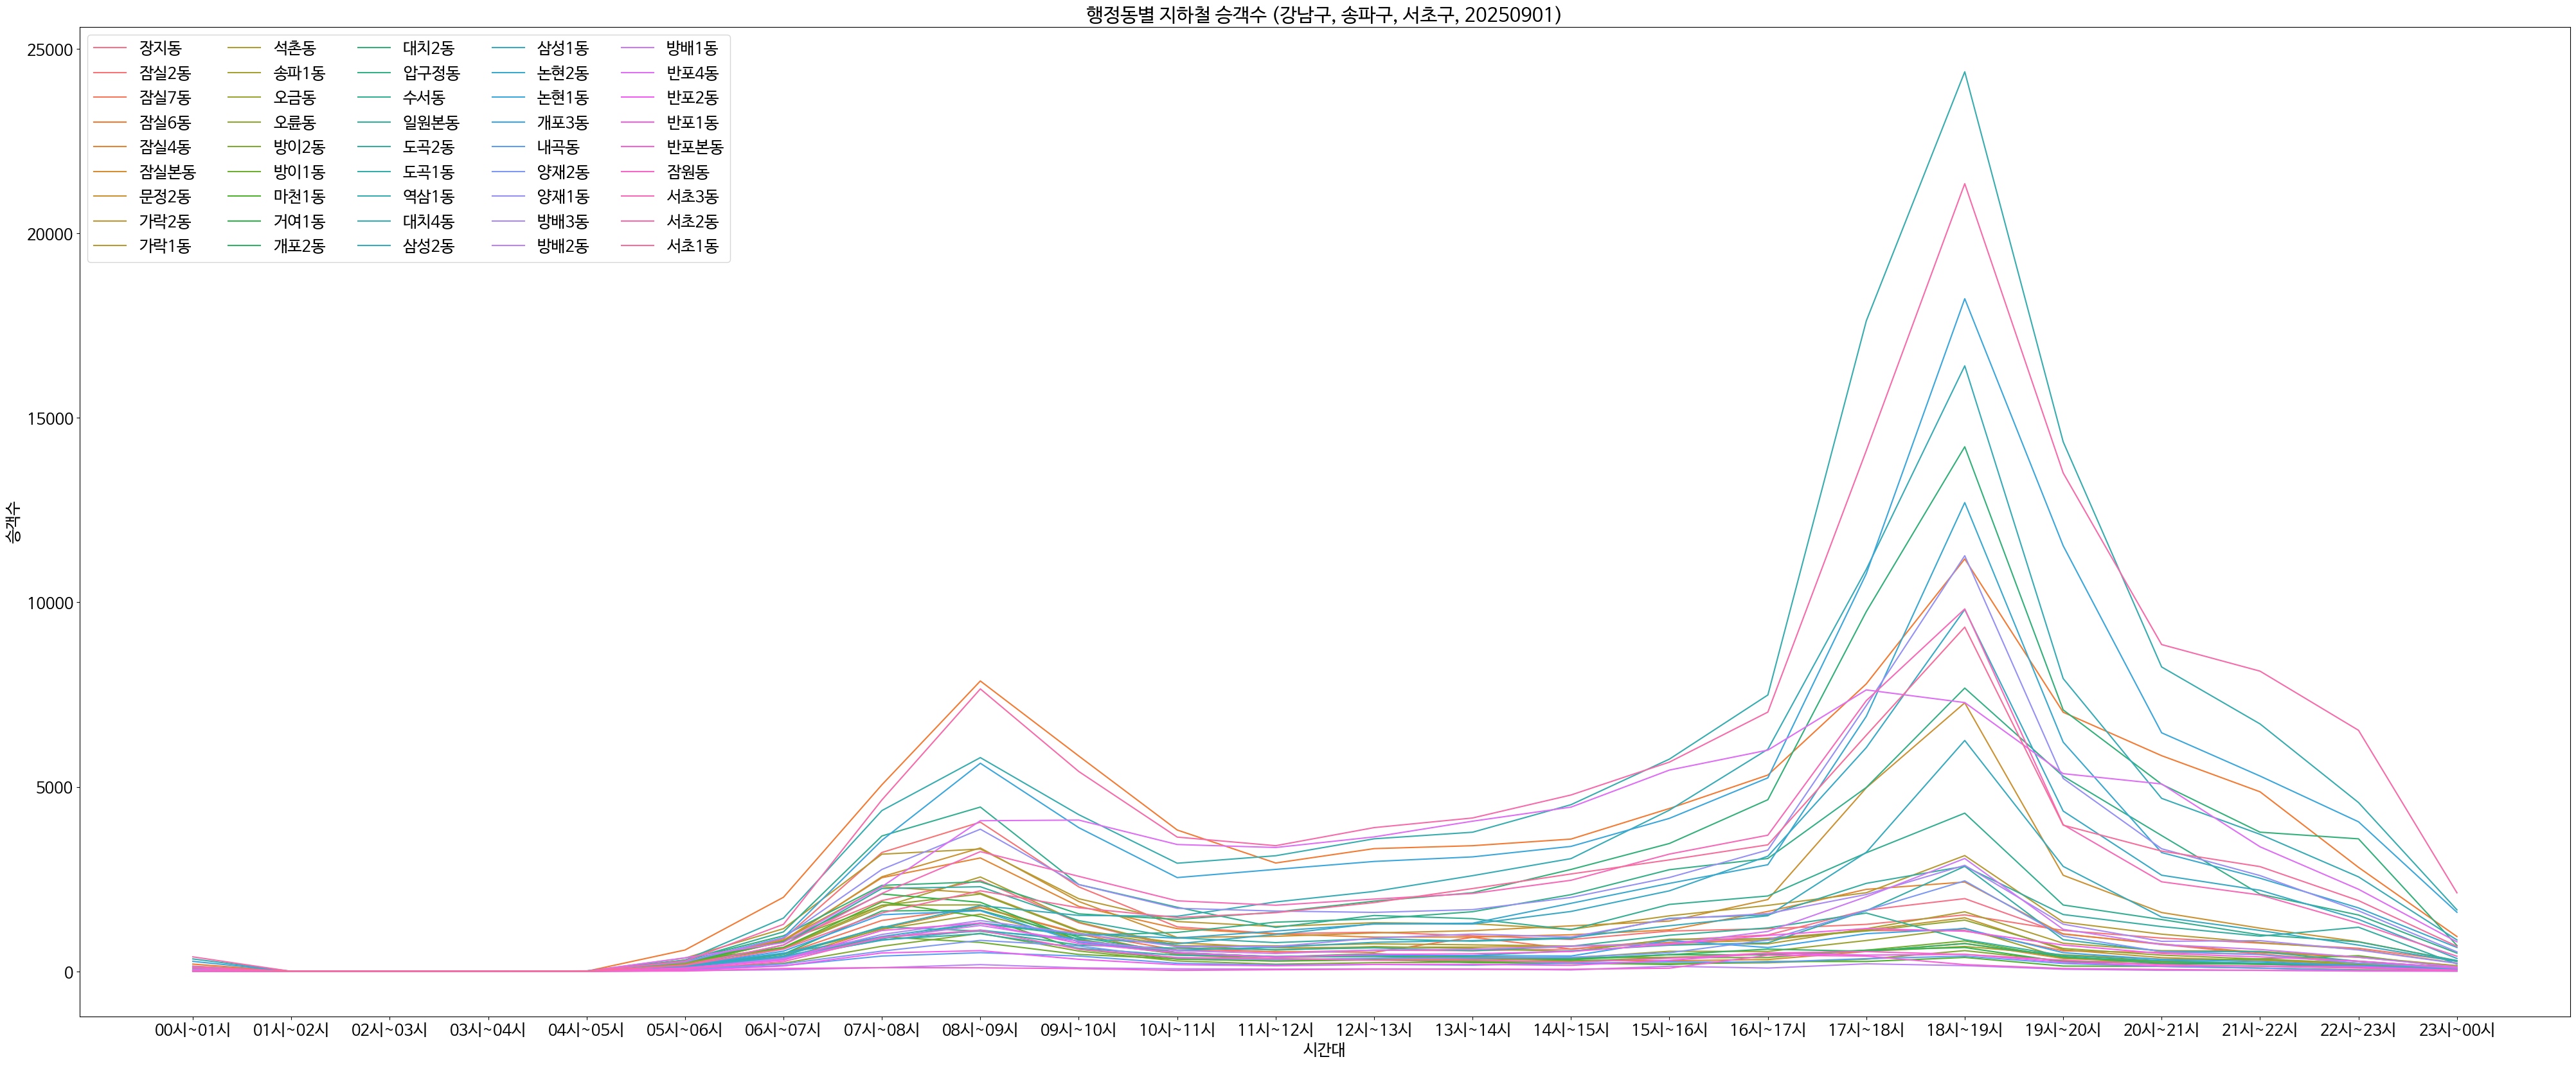

In [50]:
#시각화
#원하는 자치구에 속한 행정동들의 지하철 승객수를 시간대별로 시각화
palette = sns.color_palette('hls', len(info_integre_melt['행정동_명칭'].unique()))
plt.figure(figsize = (50, 20))
ax = sns.lineplot(data = info_integre_melt, x = '시간대', y = '시간대별_승객수', hue = '행정동_명칭', errorbar = None)
plt.legend(ncol = 5)
ax.set(xlabel = '시간대', ylabel = '승객수', title = '행정동별 지하철 승객수 (' + town_label[0] + ', ' + town_label[1]+ ', ' + town_label[2]+ ', ' + str(day_label[0]) + ')')

plt.show()

In [38]:
#원하는 월과 원하는 지하철 호수의 이용정보를 시각화
#원하는 월의 지하철 이용정보
month_label = [202509] #원하는 월 배열
subway_info_custom = subway_info.loc[subway_info['사용월'].isin(month_label)]

#원하는 자치구 지하철호선 이용정보
line_label = ['1호선', '2호선', '3호선', '4호선', '5호선', '6호선', '7호선', '8호선', '9호선'] #원하는 지하철 호선 배열
subway_info_custom = subway_info_custom.loc[subway_info_custom['호선명'].isin(line_label)]

#호선별 이용자수 합계 구하기
subway_info_hue_line = subway_info_custom.groupby('호선명')[['00시~01시', '01시~02시', '02시~03시', '03시~04시', '04시~05시', '05시~06시', '06시~07시', '07시~08시', '08시~09시', '09시~10시', '10시~11시', '11시~12시',
                                                   '12시~13시','13시~14시', '14시~15시', '15시~16시', '16시~17시', '17시~18시', '18시~19시', '19시~20시', '20시~21시', '21시~22시', '22시~23시', '23시~00시']].sum()
subway_info_hue_line.reset_index(inplace = True)

#데이터 melt
#시간대별로 행을 나눠 시각화 하기 유리하게 데이터 변환
id_cols = ['호선명']
hour_cols = ['00시~01시', '01시~02시', '02시~03시', '03시~04시', '04시~05시', '05시~06시', '06시~07시', '07시~08시', '08시~09시', '09시~10시', '10시~11시', '11시~12시',
             '12시~13시','13시~14시', '14시~15시', '15시~16시', '16시~17시', '17시~18시', '18시~19시', '19시~20시', '20시~21시', '21시~22시', '22시~23시', '23시~00시']

subway_info_melt = pd.melt(subway_info_hue_line, id_vars = id_cols, value_vars = hour_cols, var_name = '시간대', value_name = '시간대별_승객수')

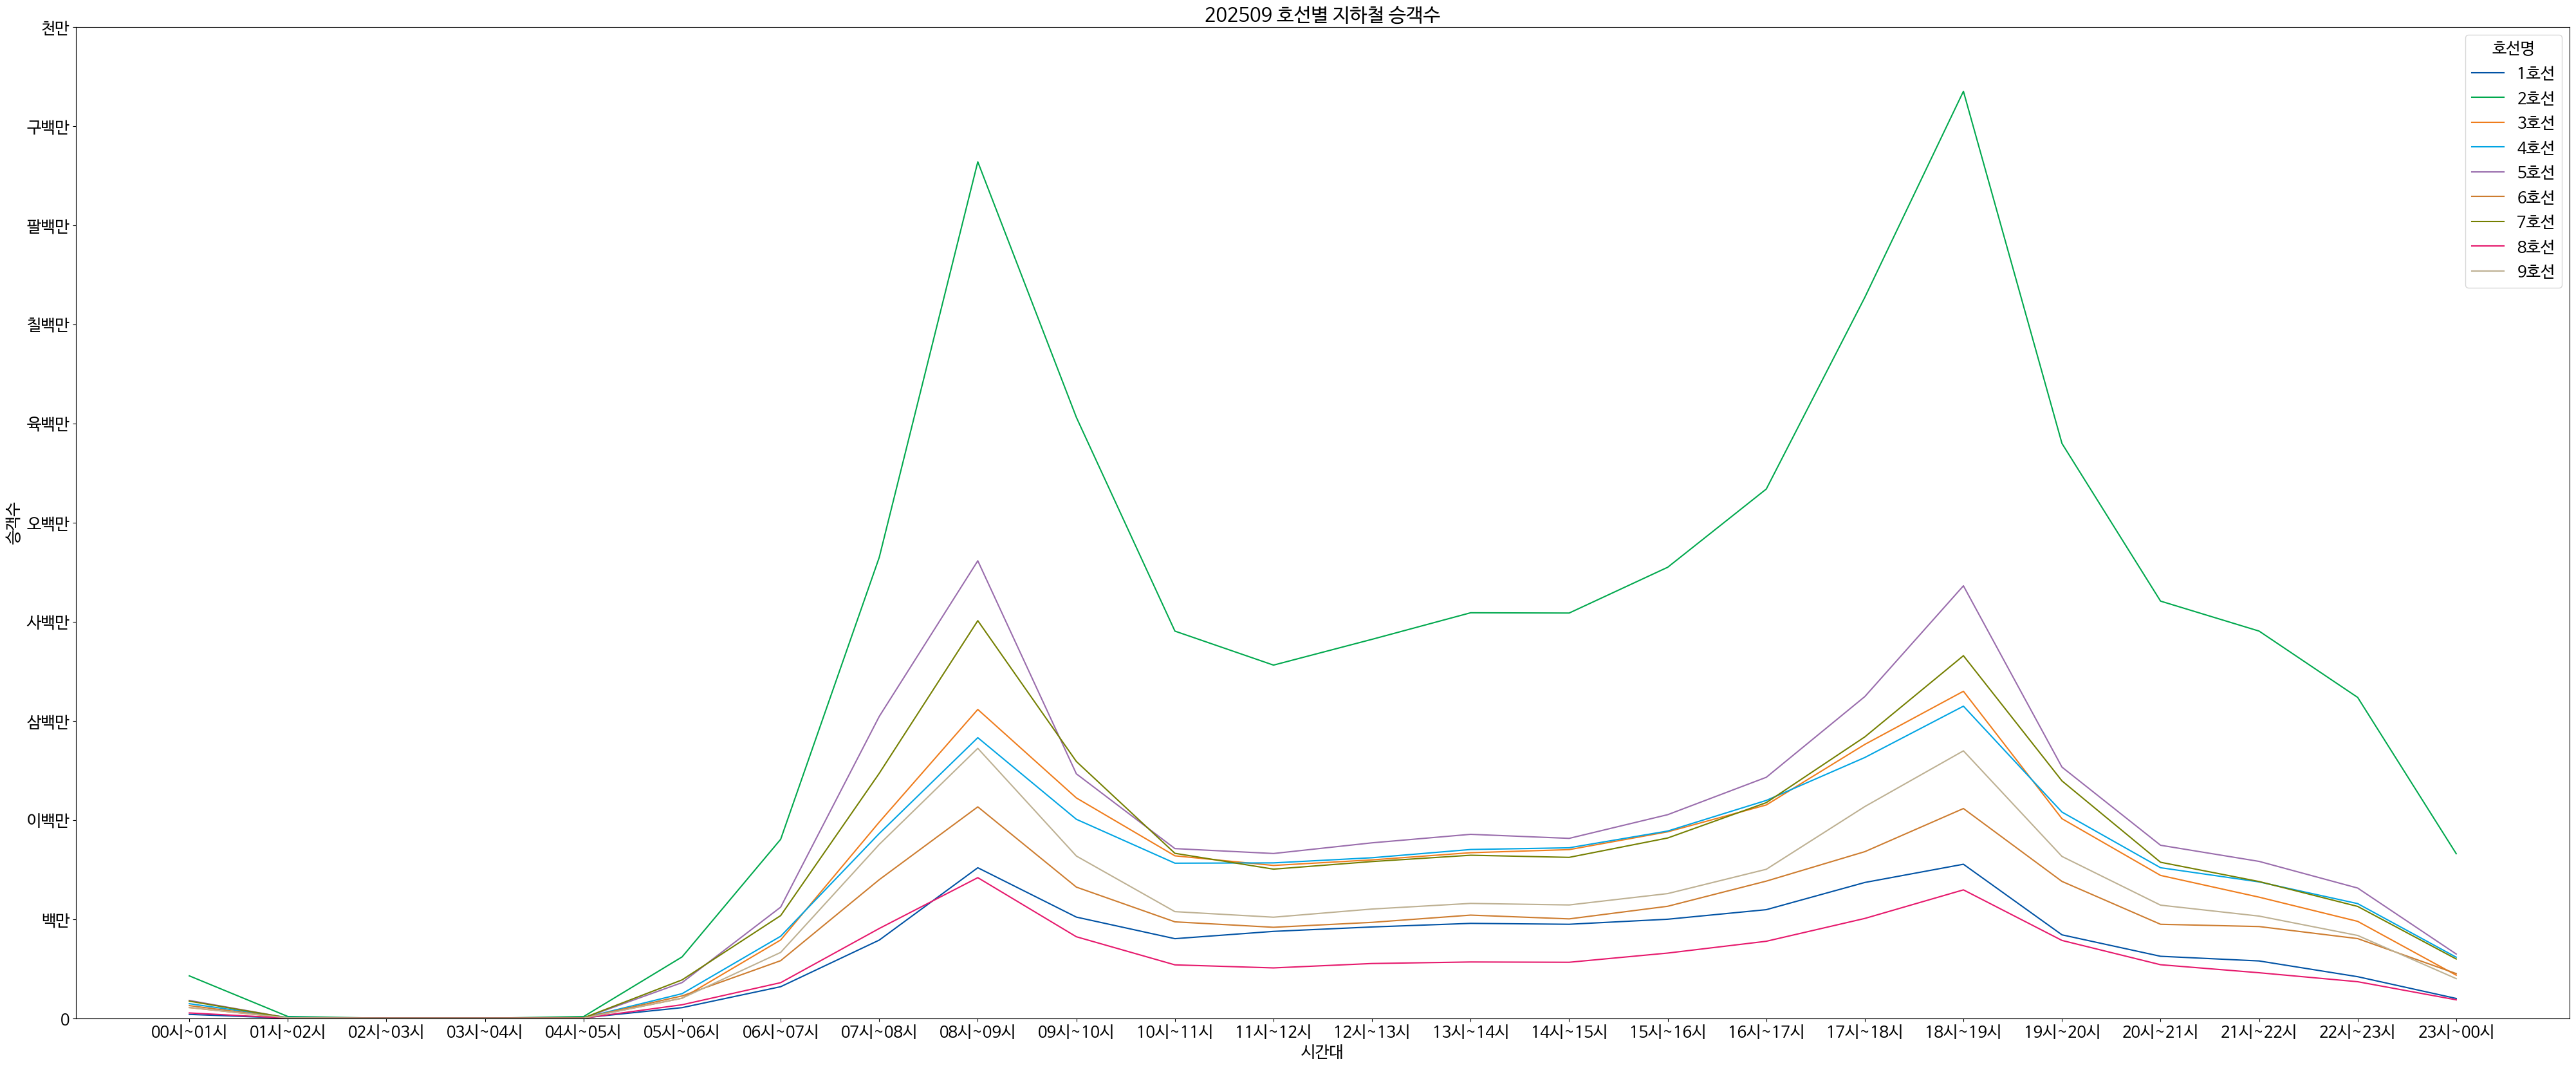

In [39]:
#시각화
#원하는 호선의 지하철 승객수를 시간대별로 시각화
plt.figure(figsize = (50, 20))
ax = sns.lineplot(data = subway_info_melt, x = '시간대', y = '시간대별_승객수', hue = '호선명', errorbar = None, palette = ['#0052A4', '#00A84D', '#EF7C1C', '#00A4E3', '#996CAC', '#CD7C2F', '#747F00', '#E6186C', '#BDB092'])
ax.set_yticks([0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000])
ax.set_yticklabels(['0', '백만', '이백만', '삼백만', '사백만', '오백만', '육백만', '칠백만', '팔백만', '구백만', '천만'])
ax.set(xlabel = '시간대', ylabel = '승객수', title = str(month_label[0]) + ' 호선별 지하철 승객수', ylim = (0, 10000000))

plt.show()

In [81]:
#원하는 월과 원하는 지하철 호수의 이용정보를 시각화
#원하는 월의 지하철 이용정보
month_label = [202509] #원하는 월 배열
subway_info_cutom = subway_info.loc[subway_info['사용월'].isin(month_label)]

#원하는 자치구 지하철호선 이용정보
line_label = ['9호선'] #원하는 지하철 호선 배열
subway_info_cutom = subway_info_cutom.loc[subway_info_cutom['호선명'].isin(line_label)]

#데이터 melt
#시간대별로 행을 나눠 시각화 하기 유리하게 데이터 변환
id_cols = ['사용월', '호선명', '지하철역']
hour_cols = ['00시~01시', '01시~02시', '02시~03시', '03시~04시', '04시~05시', '05시~06시', '06시~07시', '07시~08시', '08시~09시', '09시~10시', '10시~11시', '11시~12시',
             '12시~13시','13시~14시', '14시~15시', '15시~16시', '16시~17시', '17시~18시', '18시~19시', '19시~20시', '20시~21시', '21시~22시', '22시~23시', '23시~00시']

subway_info_melt = pd.melt(subway_info_cutom, id_vars = id_cols, value_vars = hour_cols, var_name = '시간대', value_name = '시간대별_승객수')


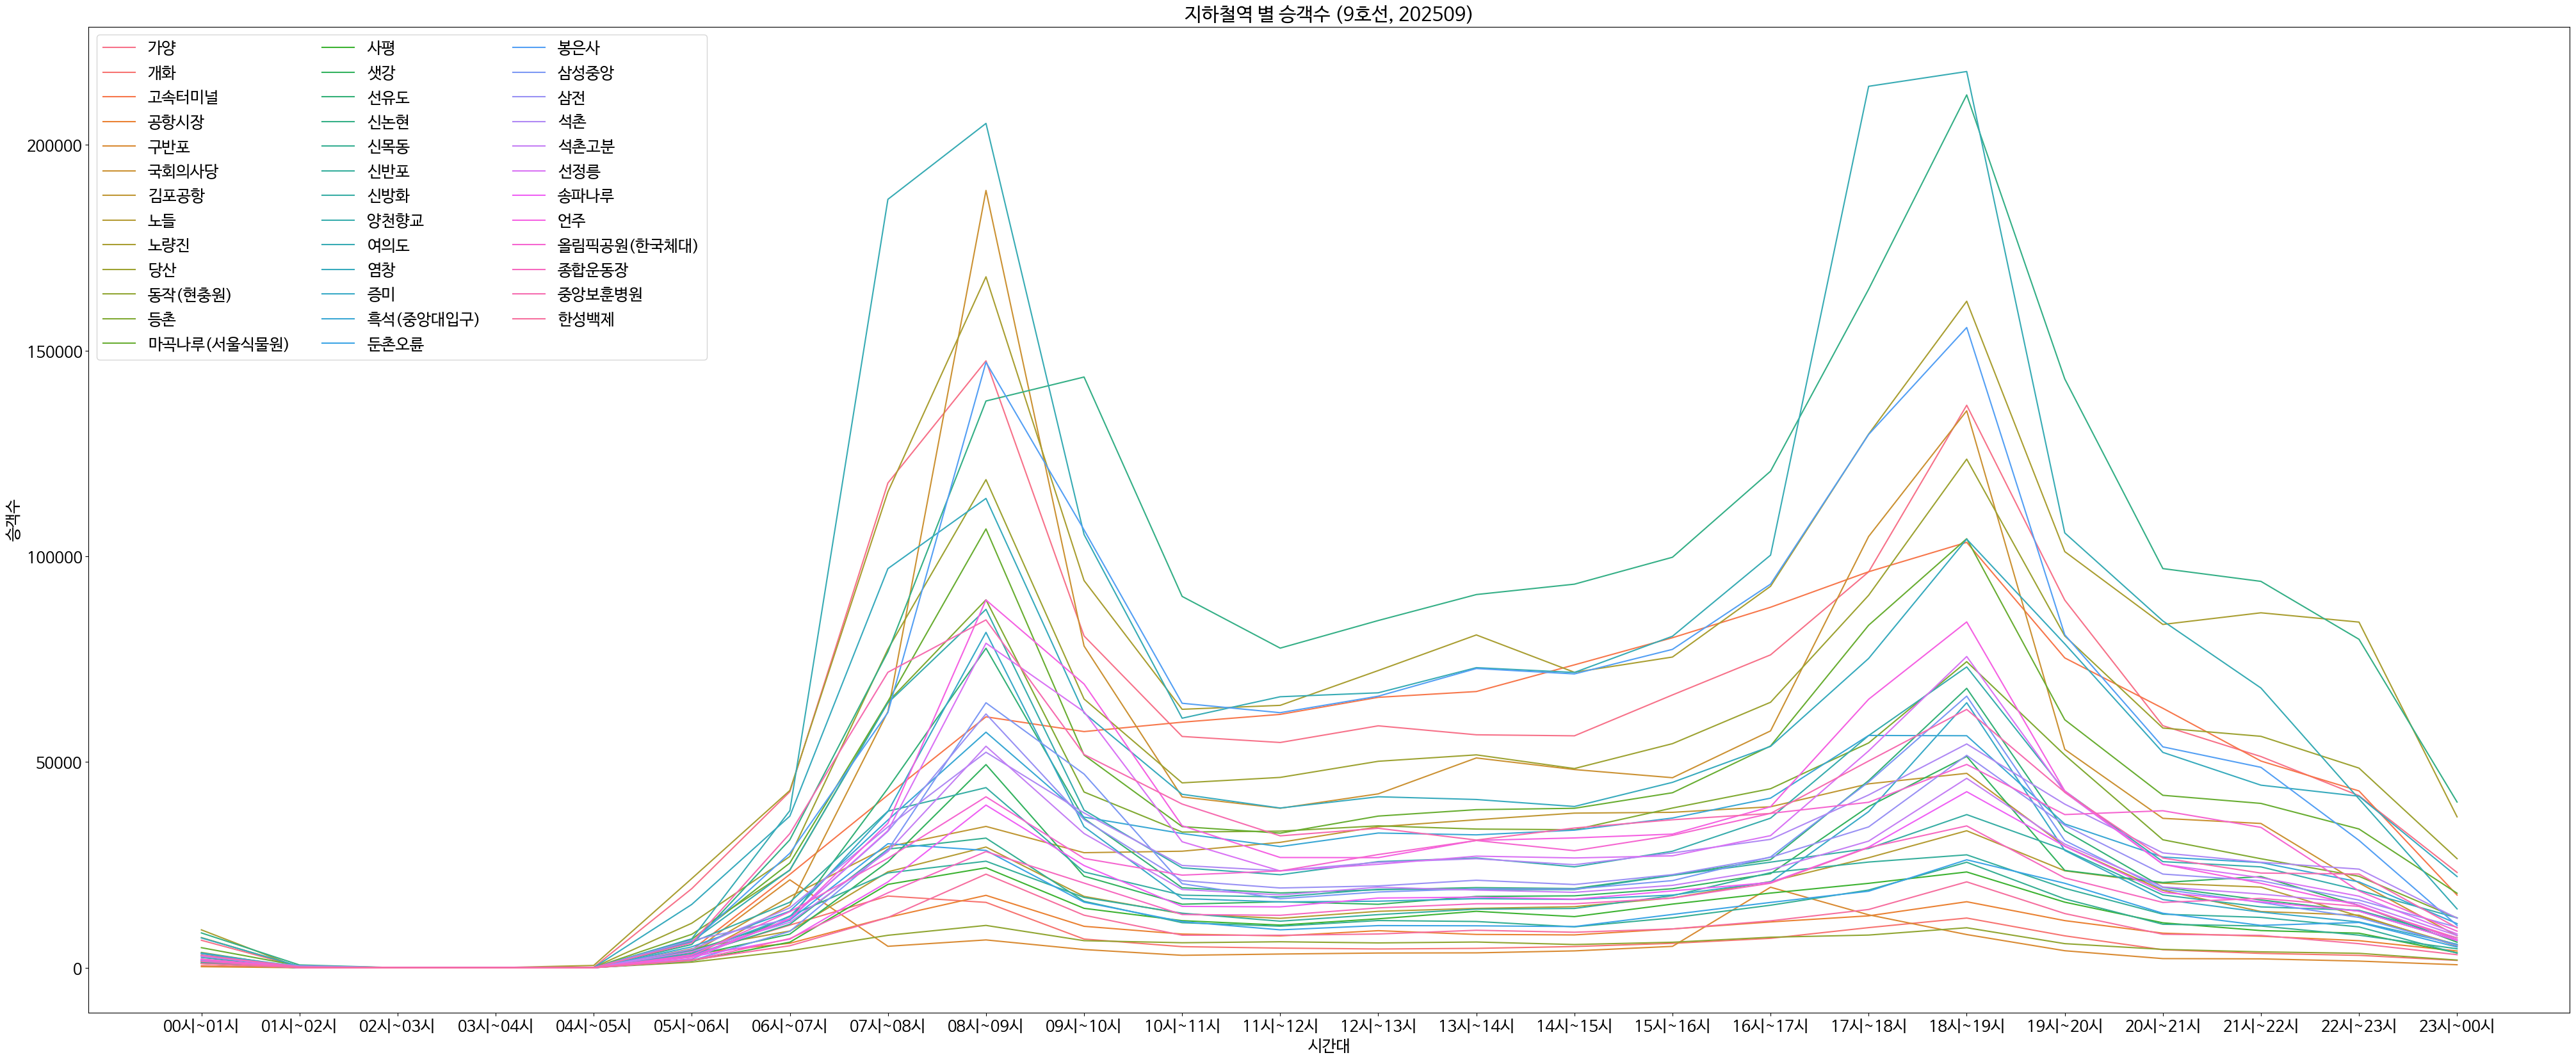

In [83]:
#시각화
#원하는 호선의 지하철 승객수를 시간대별로 시각화
fig = plt.figure(figsize = (50, 20))

ax = sns.lineplot(data = subway_info_melt, x = '시간대', y = '시간대별_승객수', hue = '지하철역', errorbar = None)
plt.legend(ncol = 3)
ax.set(xlabel = '시간대', ylabel = '승객수', title = '지하철역 별 승객수 ('+ line_label[0]+ ', ' + str(month_label[0]) +')')

plt.show()